In [ ]:
# default_exp tabular.interpretation

# tabular.interpretation

> Useful interpretation functions for tabular, such as Feature Importance

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai.tabular.all import *
from scipy.cluster import hierarchy as hc
from sklearn import manifold

In [ ]:
#export
def base_error(err, val):
    try: return (err-val)/err
    except ZeroDivisionError: return np.nan

In [ ]:
#export
@patch
def feature_importance(x:TabularLearner, df=None, dl=None, perm_func=base_error, metric=accuracy, bs=None, reverse=True, plot=True):
    "Calculate and plot the Feature Importance based on `df`"
    x.df = df
    bs = bs if bs is not None else x.dls.bs
    if df is not None:
        dl = x.dls.test_dl(df, bs=bs)
    else:
        dl = x.dls[1]
    x_names = x.dls.x_names.filter(lambda x: '_na' not in x)
    na = x.dls.x_names.filter(lambda x: '_na' in x)
    y = x.dls.y_names
    orig_metrics = x.metrics
    x.metrics = [metric]    
    try:
        results = _calc_feat_importance(x, dl, x_names, na, perm_func, reverse)
        if plot:
            _plot_importance(_ord_dic_to_df(results))
    finally: # Restore original metrics
        x.metrics = orig_metrics
        
    return results

In [ ]:
#export
def _measure_col(learn:TabularLearner, dl:TabDataLoader, name:str, na:list):
    "Measures change after column permutation"
    col = [name]
    if f'{name}_na' in na: col.append(name)
    orig = dl.items[col].values
    perm = np.random.permutation(len(orig))
    dl.items[col] = dl.items[col].values[perm]
    with learn.no_bar(), learn.no_logging():
        metric = learn.validate(dl=dl)[1]
    dl.items[col] = orig
    return metric

In [ ]:
#export
def _calc_feat_importance(learn:TabularLearner, dl:TabDataLoader, x_names:list, na:list, perm_func=base_error, reverse=True):
    "Calculates permutation importance by shuffling a column by `perm_func`"
    with learn.no_bar(), learn.no_logging():
        base_error = learn.validate(dl=dl)[1]
    importance = {}
    pbar = progress_bar(x_names)
    print("Calculating Permutation Importance")
    for col in pbar:
        importance[col] = _measure_col(learn, dl, col, na)
    for key, value in importance.items():
        importance[key] = perm_func(base_error, value)
    return OrderedDict(sorted(importance.items(), key=lambda kv: kv[1], reverse=True))

In [ ]:
#export
def _ord_dic_to_df(dict:OrderedDict): return pd.DataFrame([[k,v] for k,v in dict.items()], columns=['feature','importance'])

In [ ]:
#export
def _plot_importance(df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

In [ ]:
show_doc(TabularLearner.feature_importance)

<h4 id="TabularLearner.feature_importance" class="doc_header"><code>TabularLearner.feature_importance</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>TabularLearner.feature_importance</code>(**`x`**:`TabularLearner`, **`df`**=*`None`*, **`dl`**=*`None`*, **`perm_func`**=*`base_error`*, **`metric`**=*`accuracy`*, **`bs`**=*`None`*, **`reverse`**=*`True`*, **`plot`**=*`True`*)

Calculate and plot the Feature Importance based on `df`

We can pass in sections of a `DataFrame`, but not a `DataLoader`. `perm_func` dictates how to calculate our importance, and `reverse` will determine how to sort the output

In [ ]:
#export
def _cramers_corrected_stat(cm):
    "Calculates Cramers V Statistic for categorical-categorical"
    try: chi2 = scipy.stats.chi2_contingency(cm)[0]
    except: return 0.0
    
    if chi2 == 0: return 0.0
    n = cm.sum().sum()
    phi2 = chi2 / n
    r,k = cm.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

In [ ]:
#export
def _get_cramer_v_matr(df:pd.DataFrame):
    "Calculate Cramers V statistic on every pair in `df`'s columns'"
    cols = list(df.columns)
    
    # Initialize dataframe with 1 so we won't need to fill pandas diagonal with ones :)
    corrM = pd.DataFrame(1., columns=cols, index=cols)
    for col1, col2 in progress_bar(list(itertools.combinations(cols, 2))):
        corrM.loc[col1, col2] = corrM.loc[col2, col1] = _cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    
    return corrM

In [ ]:
#export
@patch
def get_features_corr(x:TabularLearner, df:Optional[pd.DataFrame]=None,
                      cat_names=None, cont_names=None, cont_correlation='kendall'):
    "Return correlation matrix on `df` or train data"

    dl = x.dls.test_dl(df) if df is not None else x.dls.train
    cat_names = ifnone(cat_names, dl.cat_names)
    cont_names = ifnone(cont_names, dl.cont_names)
    
    # Compute correlation 
    cat_corr_matrix = _get_cramer_v_matr(dl.xs[cat_names])
    cont_corr_matrix = dl.xs[cont_names].corr(method=cont_correlation)
    return cat_corr_matrix, cont_corr_matrix

In [ ]:
#export
def _flatten_dataframe(df: pd.DataFrame) -> pd.Series:
    data = {}
    for col_name, s in df.items():
        data.update({f"{idx_name} vs {col_name}": val for idx_name, val in s.items()})
    return pd.Series(data)

def _flatten_corr_dataframe(corr_matrix: pd.DataFrame) -> pd.Series:
    """Extract dataframe upper diagonal and flat it in a Serie"""
    corr_data = {}
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[1]):
            idx_name, col_name = corr_matrix.index[i], corr_matrix.index[j]
            corr_data[f"{idx_name} vs {col_name}"] = corr_matrix.iloc[i,j]
    return pd.Series(corr_data)

In [ ]:
#export
@delegates(get_features_corr)
@patch
def get_top_features_corr(x:TabularLearner, df:Optional[pd.DataFrame]=None, thresh:float=0.8, **kwargs):
    "Grabs top pairs of correlation with a given correlation matrix on `df` or train data filtered by `thresh`"
    cat_corr, cont_corr = x.get_features_corr(df=df, **kwargs)

    cat_corr_flat = _flatten_corr_dataframe(cat_corr)
    cat_corr_flat = cat_corr_flat[cat_corr_flat.abs() > thresh].sort_values(ascending=False)
    
    cont_corr_flat = _flatten_corr_dataframe(cont_corr)
    # Get top coontinuos correlation ignoring if they are positive or negative correlated.
    abs_cont_corr = cont_corr_flat.abs()
    cont_corr_flat = cont_corr_flat[abs_cont_corr[abs_cont_corr > thresh].sort_values(ascending=False).index]
    
    return cat_corr_flat, cont_corr_flat

@patch
def get_top_corr_dict(x:TabularLearner, df, thresh:float=0.8):
    "Grabs top pairs of correlation with a given correlation matrix on `df` or train data filtered by `thresh`"
    warnings.warn('Deprecated method: use `get_top_features_corr`')
    cat_corr, cont_corr = x.get_top_features_corr(df, thresh)
    return {**cat_corr.to_dict(), **cont_corr.to_dict()}

In [ ]:
show_doc(TabularLearner.get_top_corr_dict)

<h4 id="TabularLearner.get_top_corr_dict" class="doc_header"><code>TabularLearner.get_top_corr_dict</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>TabularLearner.get_top_corr_dict</code>(**`x`**:`TabularLearner`, **`df`**, **`thresh`**:`float`=*`0.8`*)

Grabs top pairs of correlation with a given correlation matrix on `df` or train data filtered by `thresh`

This along with `plot_dendrogram` and any helper functions along the way are based upon [this](https://github.com/Pak911/fastai-tabular-interpretation/blob/master/utils.py) by Pack911 on the fastai forums. 

In [ ]:
#export
def _plot_dendrogram(corr_matrix: pd.DataFrame, leaf_font_size, ax=None):
    # Take `abs` as we don't care if correlation is positive or negative.
    corr_condensed = hc.distance.squareform(1-corr_matrix.abs().to_numpy())
    z = hc.linkage(corr_condensed, method='average')
    dendrogram = hc.dendrogram(z, labels=corr_matrix.columns, orientation='left', leaf_font_size=leaf_font_size, ax=ax)
    return dendrogram

In [ ]:
#export 
@delegates(get_features_corr)
@patch
def plot_dendrogram(x:TabularLearner, df: Optional[pd.DataFrame]=None, 
                    figsize=None, leaf_font_size=16, **kwargs):
    "Plots dendrogram for a calculated correlation matrix. `cont_correlation` could be 'spearman' or 'kendall'"
    
    # Compute correlation 
    cat_corr_matrix, cont_corr_matrix = x.get_features_corr(df=df, **kwargs)
    
    # Plot dendrogram    
    if figsize is None:
        figsize = (15, 0.02*leaf_font_size*(len(cat_names)+len(cont_names)+3))
    
    # Use constrained_layout instead of plt.tight_layout() as it's the new form.
    fig, axes = plt.subplots(2, 1, figsize=figsize, constrained_layout=True,
                             gridspec_kw={'height_ratios': [cat_corr_matrix.shape[1], cont_corr_matrix.shape[1]]})
    
    _plot_dendrogram(cat_corr_matrix, leaf_font_size, ax=axes[0])
    axes[0].set_title("Categorical features", fontdict={'fontsize': leaf_font_size*1.1})
    _plot_dendrogram(cont_corr_matrix.abs(), leaf_font_size, ax=axes[1])
    axes[1].set_title("Continuous features", fontdict={'fontsize': leaf_font_size*1.1})
    
    # plt.tight_layout()
    plt.show()


In [ ]:
show_doc(TabularLearner.plot_dendrogram)

<h4 id="TabularLearner.plot_dendrogram" class="doc_header"><code>TabularLearner.plot_dendrogram</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>TabularLearner.plot_dendrogram</code>(**`x`**:`TabularLearner`, **`df`**:`Optional`\[`DataFrame`\]=*`None`*, **`figsize`**=*`None`*, **`leaf_font_size`**=*`16`*, **\*\*`kwargs`**)

Plots dendrogram for a calculated correlation matrix. `cont_correlation` could be 'spearman' or 'kendall'

## Example Usage

We'll run an example on the `ADULT_SAMPLE` dataset

In [ ]:
from fastai.tabular.all import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)

In [ ]:
df = pd.read_csv(path/'adult.csv')
splits = RandomSplitter()(range_of(df))
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'

In [ ]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, splits=splits)
dls = to.dataloaders()

In [ ]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)
learn.fit(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.360702,0.349341,0.834613,00:02
1,0.366281,0.351212,0.840448,00:02
2,0.360097,0.346613,0.842138,00:02


After fitting, let's first calculate the relative feature importance on the first 1,000 rows:

In [ ]:
dl = learn.dls.test_dl(df)

Calculating Permutation Importance


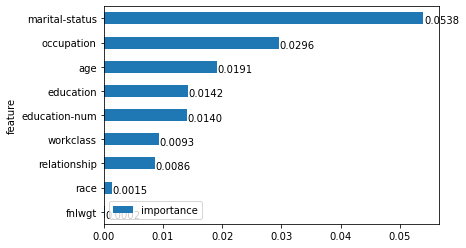

In [ ]:
fi = learn.feature_importance(df=df)

Next we'll calculate the correlation matrix, and then we will plot it's dendrogram:

In [ ]:
cat_corr, cont_corr = learn.get_features_corr()
cat_corr

,workclass,education,marital-status,occupation,relationship,race,education-num_na
workclass,1.000000,0.095213,0.084015,0.395858,0.098540,0.053928,0.009770
education,0.095213,1.000000,0.089674,0.177001,0.119536,0.071079,0.000000
marital-status,0.084015,0.089674,1.000000,0.132006,0.487846,0.081651,0.000000
occupation,0.395858,0.177001,0.132006,1.000000,0.176972,0.075789,0.477560
relationship,0.098540,0.119536,0.487846,0.176972,1.000000,0.099792,0.015502
race,0.053928,0.071079,0.081651,0.075789,0.099792,1.000000,0.011085
education-num_na,0.009770,0.000000,0.000000,0.477560,0.015502,0.011085,1.000000


In [ ]:
cont_corr

,age,fnlwgt,education-num
age,1.000000,-0.053335,0.048340
fnlwgt,-0.053335,1.000000,-0.023358
education-num,0.048340,-0.023358,1.000000


Now, we only want top correlations

In [ ]:
corr_dict = learn.get_top_corr_dict(df, thresh=0.3); corr_dict

/home/vferrer/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Deprecated method: use `get_top_features_corr`


{'occupation vs education-num_na': 0.4926685410562291,
 'marital-status vs relationship': 0.4878118703234346,
 'workclass vs occupation': 0.39672308855489463}

In [ ]:
top_cat_corr, top_cont_corr = learn.get_top_features_corr(thresh=0.3); corr_dict
top_cat_corr, top_cont_corr

(marital-status vs relationship    0.487846
 occupation vs education-num_na    0.477560
 workclass vs occupation           0.395858
 dtype: float64,
 Series([], dtype: float64))

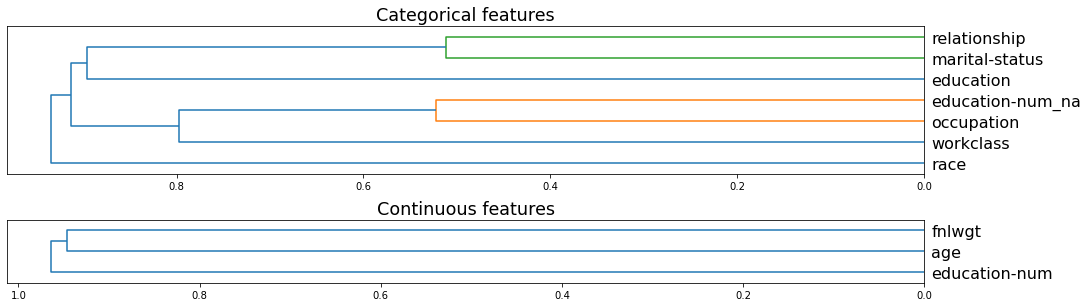

In [ ]:
learn.plot_dendrogram()